In [1]:
import numpy as np
from tqdm import tqdm
import os
import json

from videograph import VideoGraph
from utils.general import *
from utils.video_processing import *
from utils.chat_api import *
from prompts import *

from face_processing import process_faces
from voice_processing import process_voices
from memory_processing import (
    process_captions,
    generate_captions_and_thinkings_with_ids,
)
from retrieve import answer_with_retrieval

/usr/local/lib/python3.9/dist-packages/bytedtrace/__init__.py:108: UserWarning: [bytedtrace] global tracer is already initialized.
  warnings.warn('[bytedtrace] global tracer is already initialized.')


In [ ]:
def process_segment(video_graph, base64_video, base64_frames, base64_audio):

    id2voices = process_voices(video_graph, base64_audio, base64_video)
    print("Finish processing voices")

    print(f"processing {len(base64_frames)} frames...")

    id2faces = process_faces(video_graph, base64_frames)
    # print(id2faces.keys())
    print("Finish processing faces")

    episodic_captions, semantic_captions = generate_captions_and_thinkings_with_ids(
        video_graph,
        base64_video,
        base64_frames,
        base64_audio,
        id2faces,
        id2voices,
    )

    process_captions(video_graph, episodic_captions, type="episodic")
    process_captions(video_graph, semantic_captions, type="semantic")

    print("Finish processing segment")


def streaming_process_video(
    video_graph, video_path, interval_seconds, fps, segment_limit=None
):
    """Process video segments at specified intervals with given fps.

    Args:
        video_graph (VideoGraph): Graph object to store video information
        video_path (str): Path to the video file or directory containing clips
        interval_seconds (float): Time interval between segments in seconds
        fps (float): Frames per second to extract from each segment

    Returns:
        None: Updates video_graph in place with processed segments
    """
    if os.path.isfile(video_path):
        # Process single video file
        video_info = get_video_info(video_path)
        print(video_info)

        # Process each interval
        count = 0
        for start_time in np.arange(0, video_info["duration"], interval_seconds):
            if start_time + interval_seconds > video_info["duration"]:
                break

            print("=" * 20)
            count += 1

            print(f"Loading {count}-th clip starting at {start_time} seconds...")
            base64_video, base64_frames, base64_audio = process_video_clip(
                video_path, start_time, interval_seconds, fps, audio_format="wav"
            )

            # check dtype
            # print(type(base64_video), type(base64_frames[0]), type(base64_audio))

            # Process frames for this interval
            if base64_frames:
                print(
                    f"Starting processing {count}-th clip starting at {start_time} seconds..."
                )
                process_segment(
                    video_graph,
                    base64_video,
                    base64_frames,
                    base64_audio,
                )

            if segment_limit is not None and count >= segment_limit:
                break

    elif os.path.isdir(video_path):
        # Process directory of numbered clips
        files = os.listdir(video_path)
        # Filter for video files and sort by numeric value in filename
        video_files = [
            f for f in files if any(f.endswith(ext) for ext in [".mp4", ".avi", ".mov"])
        ]
        video_files.sort(key=lambda x: int("".join(filter(str.isdigit, x))))

        for count, video_file in enumerate(video_files, 1):
            print("=" * 20)
            full_path = os.path.join(video_path, video_file)
            print(f"Processing clip {count}: {full_path}")

            base64_video, base64_frames, base64_audio = process_video_clip(
                full_path, 0, None, fps, audio_format="wav"
            )

            if base64_frames:
                process_segment(
                    video_graph,
                    base64_video,
                    base64_frames,
                    base64_audio,
                )

            if segment_limit is not None and count >= segment_limit:
                break

In [ ]:
processing_config = json.load(open("configs/processing_config.json"))
memory_config = json.load(open("configs/memory_config.json"))
# video paths can be paths to directories or paths to mp4 files
video_paths = processing_config["video_paths"]

for video_path in video_paths:

    video_graph = VideoGraph(**memory_config)

    streaming_process_video(
        video_graph,
        video_path,
        processing_config["interval_seconds"],
        processing_config["fps"],
        processing_config["segment_limit"],
    )

    video_graph.refresh_equivalences()

    save_dir = "data/video_graphs"
    save_video_graph(
        video_graph, video_path, save_dir, (processing_config, memory_config)
    )

In [2]:
video_graph_path = "data/video_graphs/5-Poor-People-vs-1-Secret-Millionaire_60_5_5_10_20_0.3_0.6_0.75.pkl"
video_graph = load_video_graph(video_graph_path)
# for text_node in video_graph.text_nodes:
#     print(video_graph.nodes[text_node].metadata['contents'])
# for nodes, weight in video_graph.edges.items():
#     if weight > 1:
#         if video_graph.nodes[nodes[0]].type in ["episodic", "semantic"]:
#            print(video_graph.nodes[nodes[0]].metadata['contents'])
#         else:
#            print(video_graph.nodes[nodes[1]].metadata['contents'])
#         print(weight)

video_graph.text_matching_threshold = 0.4
video_graph.refresh_equivalences()

# question = 'What does Demar Randy wear?'
question = "Who has an OnlyFans account?"
answer = answer_with_retrieval(video_graph, question, query_num=10, topk=15)

# video_graph.summarize(logging=True)
# save_dir = "data/video_graphs"
# save_video_graph(
#     video_graph, None, save_dir, None, file_name='5-Poor-People-vs-1-Secret-Millionaire_60_5_5_10_20_0.3_0.6_0.75_augmented.pkl'
# )
# video_graph.visualize()

Loading video graph from data/video_graphs/5-Poor-People-vs-1-Secret-Millionaire_60_5_5_10_20_0.3_0.6_0.75.pkl


  0%|          | 0/128 [00:00<?, ?it/s]

Generating equivalences 0 times


2025-03-31 05:45:53,333 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"
  2%|▏         | 2/128 [00:00<00:35,  3.55it/s]

Generating equivalences 0 times


2025-03-31 05:45:54,076 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"
  2%|▏         | 3/128 [00:01<00:59,  2.12it/s]

Generating equivalences 0 times


2025-03-31 05:45:55,334 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"
 20%|██        | 26/128 [00:02<00:08, 12.03it/s]

Generating equivalences 0 times


2025-03-31 05:45:56,691 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"
 42%|████▏     | 54/128 [00:03<00:04, 16.21it/s]

Generating equivalences 0 times


2025-03-31 05:45:57,376 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"
 44%|████▍     | 56/128 [00:04<00:05, 12.76it/s]

Generating equivalences 0 times


2025-03-31 05:45:57,887 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"
 45%|████▍     | 57/128 [00:05<00:06, 10.42it/s]

Generating equivalences 0 times


2025-03-31 05:45:58,568 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"
 63%|██████▎   | 81/128 [00:05<00:02, 17.67it/s]

Generating equivalences 0 times


2025-03-31 05:45:59,073 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"
 65%|██████▍   | 83/128 [00:06<00:03, 14.43it/s]

Generating equivalences 0 times


2025-03-31 05:45:59,446 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"
 84%|████████▍ | 108/128 [00:06<00:00, 24.93it/s]

Generating equivalences 0 times


2025-03-31 05:45:59,975 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


Generating equivalences 0 times


2025-03-31 05:46:00,327 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"
100%|██████████| 128/128 [00:07<00:00, 16.95it/s]


Generating queries 0 times


2025-03-31 05:46:02,397 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


Queries: ['Names of all characters mentioned in the story.', 'Which character is associated with social media platforms?', 'Which character is described as having an online presence?', "Details about characters' professions or hobbies.", 'Which character is involved in content creation or online activities?', 'Which character is described as having a subscription-based account?', 'Which character is linked to monetized online platforms?', 'Which character is described as engaging with fans or followers?', 'Which character is associated with adult content or similar platforms?', 'Which character has been mentioned in connection with OnlyFans or similar services?']
['<voice_0> introduces four individuals named Denny, Herm, Aaron, and JC, along with five other unnamed individuals.', '<character_4> is later revealed to have an OnlyFans account.', "<voice_55> expresses surprise at the revelation of <character_4>'s OnlyFans involvement, stating that they 'might have a million dollars.'"]


2025-03-31 05:46:05,398 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[INTERMEDIATE] <character_4> is revealed to have an OnlyFans account. Next, I need to identify the name of <character_4> to provide the final answer.
Generating queries 0 times


2025-03-31 05:46:10,899 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


Entities parsing error: invalid literal for int() with base 10: 'X'
Entities parsing error: invalid literal for int() with base 10: 'Y'
Queries: ['What is the name of <face_8>?', 'What is the name of <voice_82>?', 'Who are the five unnamed individuals introduced by <voice_0>?', "Which character is associated with <voice_55>'s surprise about an OnlyFans account?", "Does <voice_55> mention any specific names when reacting to <face_8>'s OnlyFans account?", "Does <voice_55> mention any specific names when reacting to <voice_82>'s OnlyFans account?", 'Are there any connections between <face_8> and the named individuals Denny, Herm, Aaron, or JC?', 'Are there any connections between <voice_82> and the named individuals Denny, Herm, Aaron, or JC?', "Which character is linked to the statement about 'having a million dollars'?", 'Does <voice_0> provide any additional details about the unnamed individuals?', 'Are there any visual descriptions or actions associated with <face_8> in the memory ban

2025-03-31 05:46:12,891 - httpx - INFO - HTTP Request: POST https://search-va.byteintl.net/gpt/openapi/online/v2/crawl/openai/deployments/gpt-4o-2024-11-20/chat/completions?api-version=2024-03-01-preview "HTTP/1.1 200 OK"


[FINAL] Labone has an OnlyFans account.


Loading video graph from data/video_graphs/5-Poor-People-vs-1-Secret-Millionaire_60_5_5_10_20_0.3_0.6_0.75.pkl


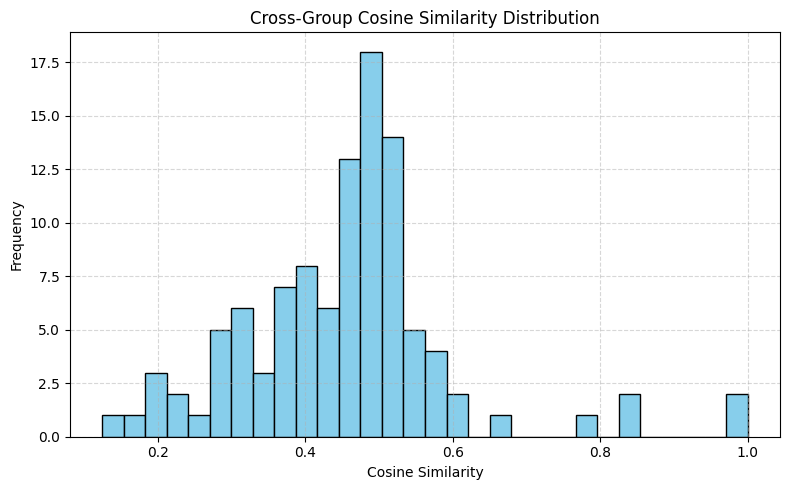

In [12]:
from utils.chat_api import *
from utils.general import plot_cosine_similarity_distribution

video_graph_path = "data/video_graphs/5-Poor-People-vs-1-Secret-Millionaire_60_5_5_10_20_0.3_0.6_0.75.pkl"
video_graph = load_video_graph(video_graph_path)

graph_embeddings = []

for id, node in video_graph.nodes.items():
    if node.type in ['episodic', 'semantic']:
        graph_embeddings.extend(node.embeddings)

# texts = ["Clothing style of Demar Randy", "<voice_44> introduces himself as Demar Randy."]
texts = ["<face_4> points at <face_9>."]
embs = parallel_get_embedding('text-embedding-3-large', texts)[0]

plot_cosine_similarity_distribution(graph_embeddings, embs)


In [3]:
for text_node in video_graph.text_nodes:
    print(video_graph.nodes[text_node].metadata["contents"])

['<voice_0> introduces four individuals named Denny, Herm, Aaron, and JC, along with five other unnamed individuals.']
['<voice_0> explains the premise of the video: only one of the five unnamed people is a millionaire, while the other four are not.']
['<face_9> wears a black jacket, a plaid shirt, and jeans.']
['<face_7> wears a purple jacket and black pants.']
['<face_3> points at <face_9> while laughing.']
['<face_4> points at <face_9>.']
["<voice_1> states, 'Got bills.'"]
["<face_3> says, 'Cuz you was in the guest of Black Privilege, and I think we had to pay him.'"]
['<face_8> wears a white, long-sleeved, collared shirt and khaki pants.']
['<face_10> wears no socks with his loafers.']
['Equivalence: <face_3>, <voice_2>']
['Equivalence: <face_9>, <voice_1>']
['<face_9> is being accused of not being a millionaire because he was previously a guest on Black Privilege and needed to be paid for his appearance.']
['<face_10> is considered to be well-off financially based on the observati

In [ ]:
video_graph.visualize()

In [ ]:
# from retrieve import retrieve_from_videograph
# from videograph import VideoGraph
# from utils.chat_api import (
#     generate_messages,
#     get_response_with_retry,
#     parallel_get_embedding,
# )
# from utils.general import validate_and_fix_python_list
# from prompts import prompt_memory_retrieval

# MAX_RETRIES = 3


# def generate_queries(question, existing_knowledge=None, query_num=1):
#     input = [
#         {
#             "type": "text",
#             "content": prompt_memory_retrieval.format(
#                 question=question,
#                 query_num=query_num,
#                 existing_knowledge=existing_knowledge,
#             ),
#         }
#     ]
#     messages = generate_messages(input)
#     model = "gpt-4o-2024-11-20"
#     queries = None
#     for i in range(MAX_RETRIES):
#         print(f"Generating queries {i} times")
#         queries = get_response_with_retry(model, messages)[0]
#         queries = validate_and_fix_python_list(queries)
#         if queries is not None:
#             break
#     if queries is None:
#         raise Exception("Failed to generate queries")
#     return queries


# def retrieve_from_videograph(videograph, question, topk=3):
#     queries = generate_queries(question)
#     print(f"Queries: {queries}")

#     model = "text-embedding-3-large"
#     query_embeddings = parallel_get_embedding(model, queries)[0]

#     related_nodes = []

#     for query_embedding in query_embeddings:
#         nodes = videograph.search_text_nodes(query_embedding)
#         related_nodes.extend(nodes)

#     related_nodes = list(set(related_nodes))
#     return related_nodes


# question = "Denny"
# retrieved_nodes = retrieve_from_videograph(video_graph, question)
# print(retrieved_nodes)